### Fashi_mnist 手写Dropout DNN

dict_keys(['image', 'label'])
<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x17932ADD9D0>
9


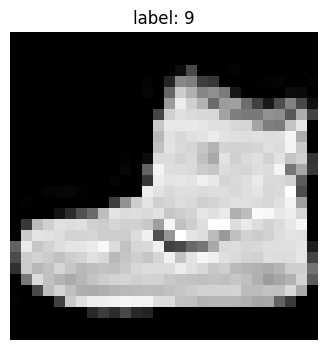

In [71]:
from datasets import load_from_disk
import matplotlib.pyplot as plt

dataset  = load_from_disk("D:/AILearn/Deep learning network/node/data/fashion_mnist")

train_data = dataset["train"]
test_data = dataset["test"]
sample = train_data[0]
print(sample.keys())
print(sample["image"])
print(sample["label"])

plt.figure(figsize=(4, 4))
plt.imshow(sample["image"],cmap="gray")  # 使用灰度色彩映射
plt.title(f'label: {sample["label"]}')
plt.axis('off')  # 不显示坐标轴
plt.show()



In [72]:
import torch
import torchvision
import torch.nn as nn

device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def transform_example(example):
    example["image"] = torchvision.transforms.ToTensor()(example["image"])
    example["image"] = torchvision.transforms.Normalize(mean = [0.5],std = [0.5])(example["image"])
    example["label"] = torch.tensor(example["label"],dtype = torch.int64)
    return example

train = train_data.map(transform_example)
test = test_data.map(transform_example)

train.set_format(type = "torch")
test.set_format(type = "torch")

train_loader = torch.utils.data.DataLoader(train,batch_size = 32,shuffle = True)
test_loader = torch.utils.data.DataLoader(test,batch_size = 32,shuffle = False)

In [73]:
class CustomDropout(torch.nn.Module):
    def __init__(self,p=0.5):
        super(CustomDropout,self).__init__()
        self.p = p
    def forward(self,x):
        if self.training:
            mask = torch.rand_like(x) > self.p
            return x * mask.float() / (1 - self.p)
        return x





class DeepNN(torch.nn.Module):
    def __init__(self, input_size=784, hidden_size=[128,64,32], output_size=10):
        super(DeepNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size[0])
        self.fc2 = torch.nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = torch.nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = torch.nn.Linear(hidden_size[2], output_size)
        self.dropout = CustomDropout(p=0.2)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        #x = self.softmax(x)
        return x

In [74]:
def train(model,train_loader,criterion,optimizer,epoch=5,visualize=True):
    model.train()
    loss_list = []
    for epoch in range(epoch):
        running_loss = 0.0
        for i,data in enumerate(train_loader):
            inputs,labels = data["image"].to(device),data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print(f"[{epoch+1},{i+1:5d}] loss:{running_loss/100:.3f}")
                running_loss = 0.0
    if visualize:
        plt.plot(loss_list)
        plt.title("Training Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()
    return model

In [75]:
def test(model,test_loader):
    model.eval()  # 设置模型为评估模式，关闭Dropout等训练时的操作
    correct = 0
    total = 0
    with torch.no_grad():  # 不计算梯度，减少内存消耗
        for data in test_loader:
            inputs, labels = data['image'].to(device), data['label'].to(device)
            outputs = model(inputs)  
            _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
            total += labels.size(0)  # 统计总样本数
            correct += (predicted == labels).sum().item()  # 统计正确预测的样本数
    accuracy = correct / total  # 计算准确率
    print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f}%')  # 输出准确率

[1,  100] loss:1.252
[1,  200] loss:0.969
[1,  300] loss:0.952
[1,  400] loss:0.868
[1,  500] loss:0.899
[1,  600] loss:0.864
[1,  700] loss:0.949
[1,  800] loss:0.856
[1,  900] loss:0.918
[1, 1000] loss:0.868
[1, 1100] loss:0.859
[1, 1200] loss:0.905
[1, 1300] loss:0.814
[1, 1400] loss:0.796
[1, 1500] loss:0.824
[1, 1600] loss:0.897
[1, 1700] loss:0.899
[1, 1800] loss:0.847
[2,  100] loss:0.784
[2,  200] loss:0.894
[2,  300] loss:0.905
[2,  400] loss:0.844
[2,  500] loss:0.787
[2,  600] loss:0.890
[2,  700] loss:0.815
[2,  800] loss:0.818
[2,  900] loss:0.842
[2, 1000] loss:0.853
[2, 1100] loss:0.805
[2, 1200] loss:0.916
[2, 1300] loss:0.988
[2, 1400] loss:0.912
[2, 1500] loss:0.853
[2, 1600] loss:0.943
[2, 1700] loss:0.773
[2, 1800] loss:0.901
[3,  100] loss:0.805
[3,  200] loss:0.824
[3,  300] loss:0.780
[3,  400] loss:0.816
[3,  500] loss:0.832
[3,  600] loss:0.757
[3,  700] loss:0.858
[3,  800] loss:0.830
[3,  900] loss:0.823
[3, 1000] loss:0.921
[3, 1100] loss:0.814
[3, 1200] los

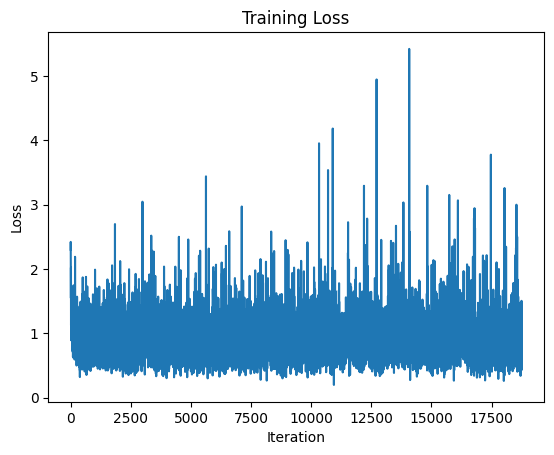

Accuracy of the network on the 10000 test images: 77.06%


In [76]:
from torch import nn

model = DeepNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_Adam = torch.optim.Adam(model.parameters(),lr=0.01) #随机梯度下降优化器
epoches = 10#训练轮数

train_model=train(model,train_loader,criterion,optimizer_Adam,epoches,True)
save_path = "D:/AILearn/Deep learning network/saved_model/fashion_mnist_model.pth"
test(model,test_loader)

torch.save(model.state_dict(),save_path)
